# 프로젝트: House Price Prediction    
* 목표는 주택 가격 예측하는 것!

## 0. 환경 세팅

### Random Seed 고정    
랜덤 시드를 고정해줌으로서 같은 결과를 볼 수 있도록 해줍니다. 랜덤 시드를 고정하는 건 항상 같은 수를 내놓는다기 보다는 항상 같은 랜덤 패턴을 가진다고 생각하시면 됩니다. 예를 들어서 컴퓨터가 랜덤하게 1->2->3을 내놓는 패턴이 랜덤 시드 1이라면, 3->2->1 식의 패턴은 랜덤 시드 2 이런 식의 패턴이 동일하게 간다는 점입니다. 

In [2]:
import random
import numpy as np 
import tensorflow as tf
import os

# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    
random_state = 3854 # 11, 2020, 3450 등 여러 파라미터를 통해 random_seed 결정
set_seeds(random_state)

seed = 3854일때, submission_lgbm_RMSLE_0.16403507171889764.csv <br>
seed = 3450일때, submission_lgbm_RMSLE_0.16579509411716917.csv <br>
seed = 2020일때, submission_lgbm_RMSLE_0.16625573978835373.csv <br>
seed = 11일때, submission_lgbm_RMSLE_0.16640884152286348.csv <br>

### 필요 라이브러리 import 

In [3]:
import warnings
warnings.filterwarnings("ignore")

# 디렉토리, 파일 시스템 관련 라이브러리 
import os
from os.path import join

import pandas as pd
import numpy as np

# 시각화 라이브러리 
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# 데이터셋 관련 라이브러리 
from sklearn.model_selection import train_test_split

# 학습 모델 라이브러리 
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 검증을 위한 라잉브러리 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

### 디렉토리 설정 및 데이터 불러오기

* [os.getcwd](http://pythonstudy.xyz/python/article/507-%ED%8C%8C%EC%9D%BC%EA%B3%BC-%EB%94%94%EB%A0%89%ED%86%A0%EB%A6%AC): 현재 Jupyternotebook이 있는 디렉토리 경로 

In [4]:
!pwd # 현재 경로 

/home/aiffel-dj19/aiffel/kaggle_kakr_housing


In [5]:
os.getcwd() # os 라이브러리를 활용한 현재 경로 

'/home/aiffel-dj19/aiffel/kaggle_kakr_housing'

* train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
* test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
* sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

In [6]:
data_path = os.path.join(os.getcwd(), 'data') # '/' 안해줘도 됨 
train_data_path = join(data_path, 'train.csv')
test_data_path = join(data_path, 'test.csv')

print(train_data_path)
print(test_data_path)

/home/aiffel-dj19/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj19/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다. <br>
pandas는 dataframe으로 데이터를 분석하기에 매우 유용한 라이브러리입니다. <br>
* 참고 링크: pandas? [pandas를 똑똑하게 쓰는 다이어트 전략](https://drive.google.com/file/d/12faqaslFIF-Sg_sU3jeGyauW5ClRqS8D/view)
---

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
**3. price : 타겟 변수인 집의 가격=> 종속 변수에 해당하고, 나머지는 독립 변수** 

4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
**18. lat : 위도**
**19. long : 경도**

20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

* baseline에서 tuning 해줬을 때, iters = 1000, depth = 10, rmsle = 0.164035
    * lat, long이 중요한 feature로 나타났습니다. 
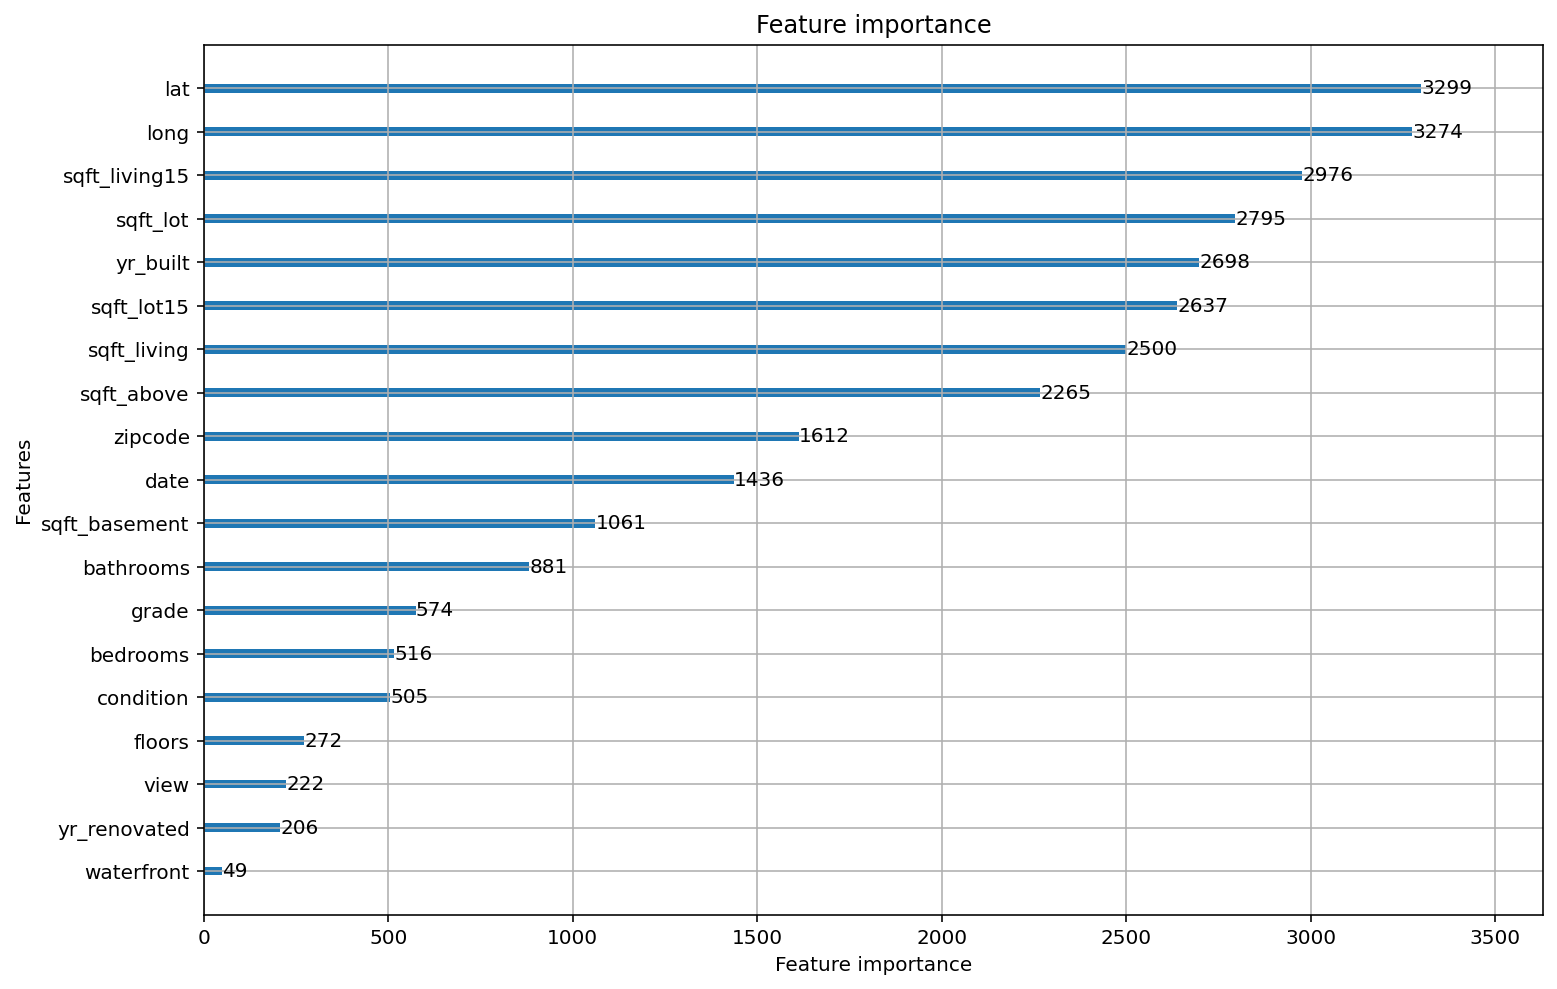

In [7]:
train = pd.read_csv(train_data_path) # csv file을 DataFrame 형태로 불러오기 
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [8]:
train.head() # train.csv dataframe 상위 5개 확인 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [9]:
test.head() # test.csv dataframe 상위 5개 확인 

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 1.1. 학습 데이터에서 라벨 제거
* [del](https://www.w3schools.com/python/ref_keyword_del.asp): 메모리 비우기, 특정 칼럼 삭제 가능 
* [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html): 특정 칼럼 삭제 

In [10]:
# ## del는 두 번 수행되면 Error뜨니까 한번만 수행하고 주석 처리 해두기 
y_train_data = train['price'] # y변수에 price 컬럼을 따로 저장
del train['price'] # 저장 후 삭제 <=> 메모리 비우기 

print(train.columns)
print(len(train.columns), '개의 칼럼이 있습니다.')

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
20 개의 칼럼이 있습니다.


### 1.2. 학습 데이터와 테스트 데이터 합치기 
EDA 분석을 할 때는 학습/테스트 데이터를 함께 살펴봅니다. 하지만, 추후에 모델 학습할 때는 테스트 데이터는 학습 대상이 아니기 때문에 train_len을 통해 train set의 개수를 저장해두고 학습데이터를 불러올 수 있는 인덱스로 사용합니다. <br>
* pd.concat 사용 

In [11]:
train_len = len(train)
x_train_data = pd.concat((train, test), axis=0)

In [12]:
x_train_data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다. <br>
### 2.1. 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

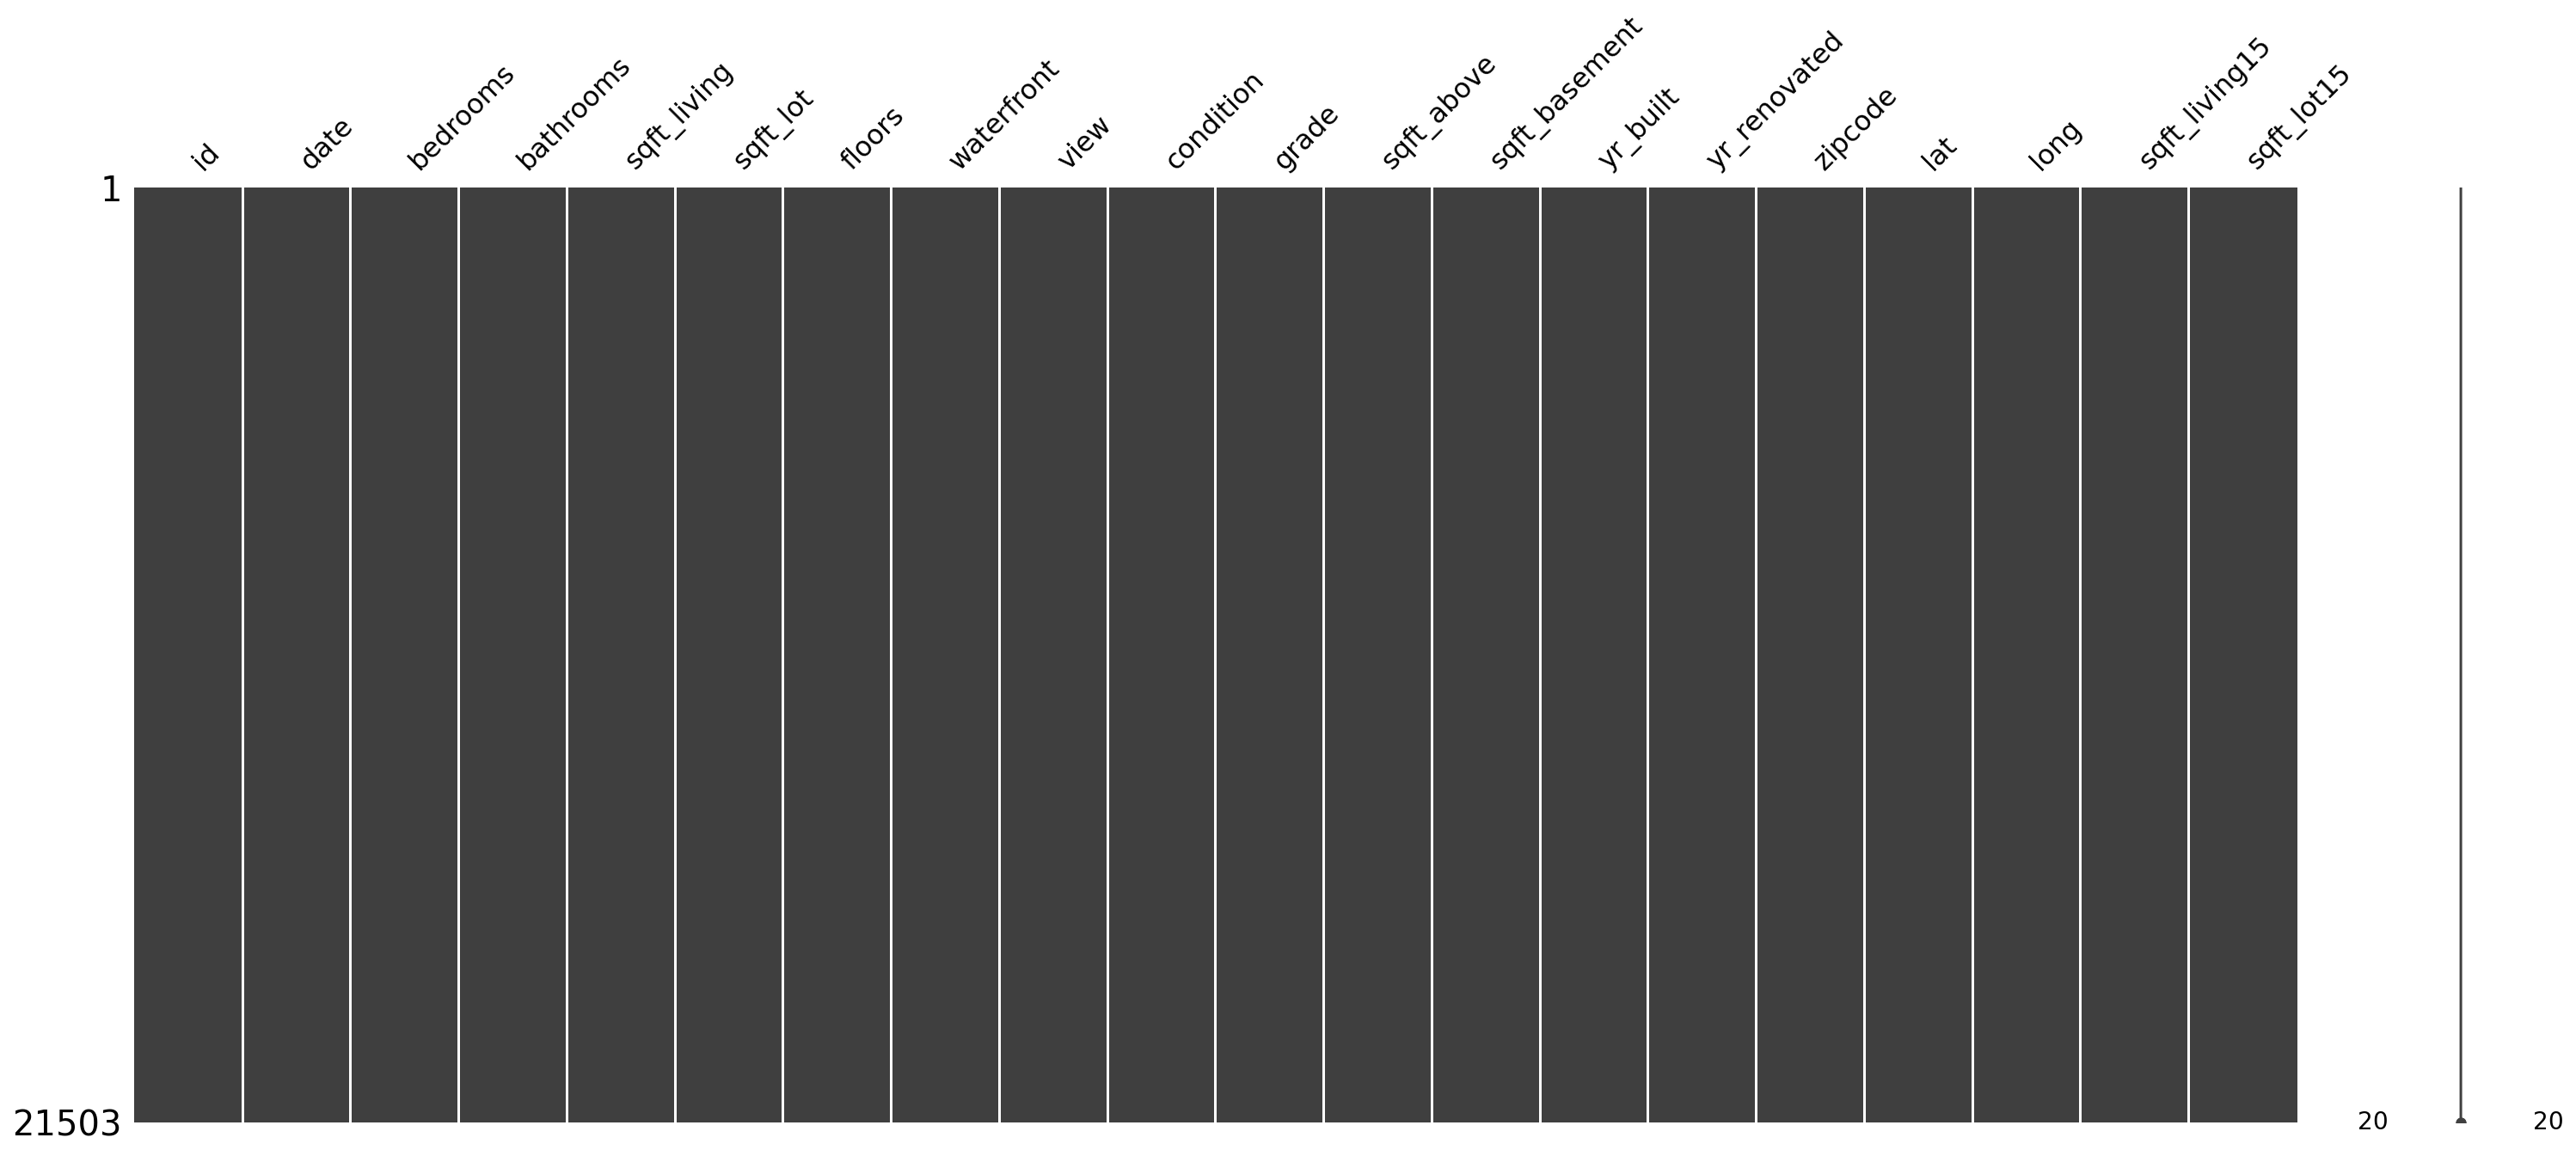

In [13]:
msno.matrix(x_train_data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>
* [DataFrame.loc](https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1#loc): 인덱싱

In [14]:
for c in x_train_data.columns:
    print('{} : {}'.format(c, len(x_train_data.loc[pd.isnull(x_train_data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2.2. id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [15]:
test_id = x_train_data['id'][train_len:]
del x_train_data['id']

In [16]:
print(x_train_data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


* [apply](https://data-newbie.tistory.com/207)
* lambda: 

#### **baseline - date를 문자열 데이터로 처리: str(x[:6]** 

In [17]:
# x_train_data['date'] = x_train_data['date'].apply(lambda x : str(x[:6])) # 201410까지 슬라이싱
# x_train_data.head()

#### **baseline과 차이점 - date를 정수형 데이터로 캐스팅: .astype(int)** 
(시도) 현재 코드에서는 i:i[:6]까지만 슬라이싱 해줬으나 date별로 price 값을 시각화로 확인하거나 아니면 <br>
실험적으로 일까지 포함한 i:i[:8]까지 했을때의 결과값 차이를 확인합니다. <br>

In [18]:
x_train_data['date'] = x_train_data['date'].apply(lambda i: i[:6]).astype(int) # date의 년도와 월까지만 가져옴 
x_train_data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 2.3. 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.
* [seaboran.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html): 이산데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인 가능 

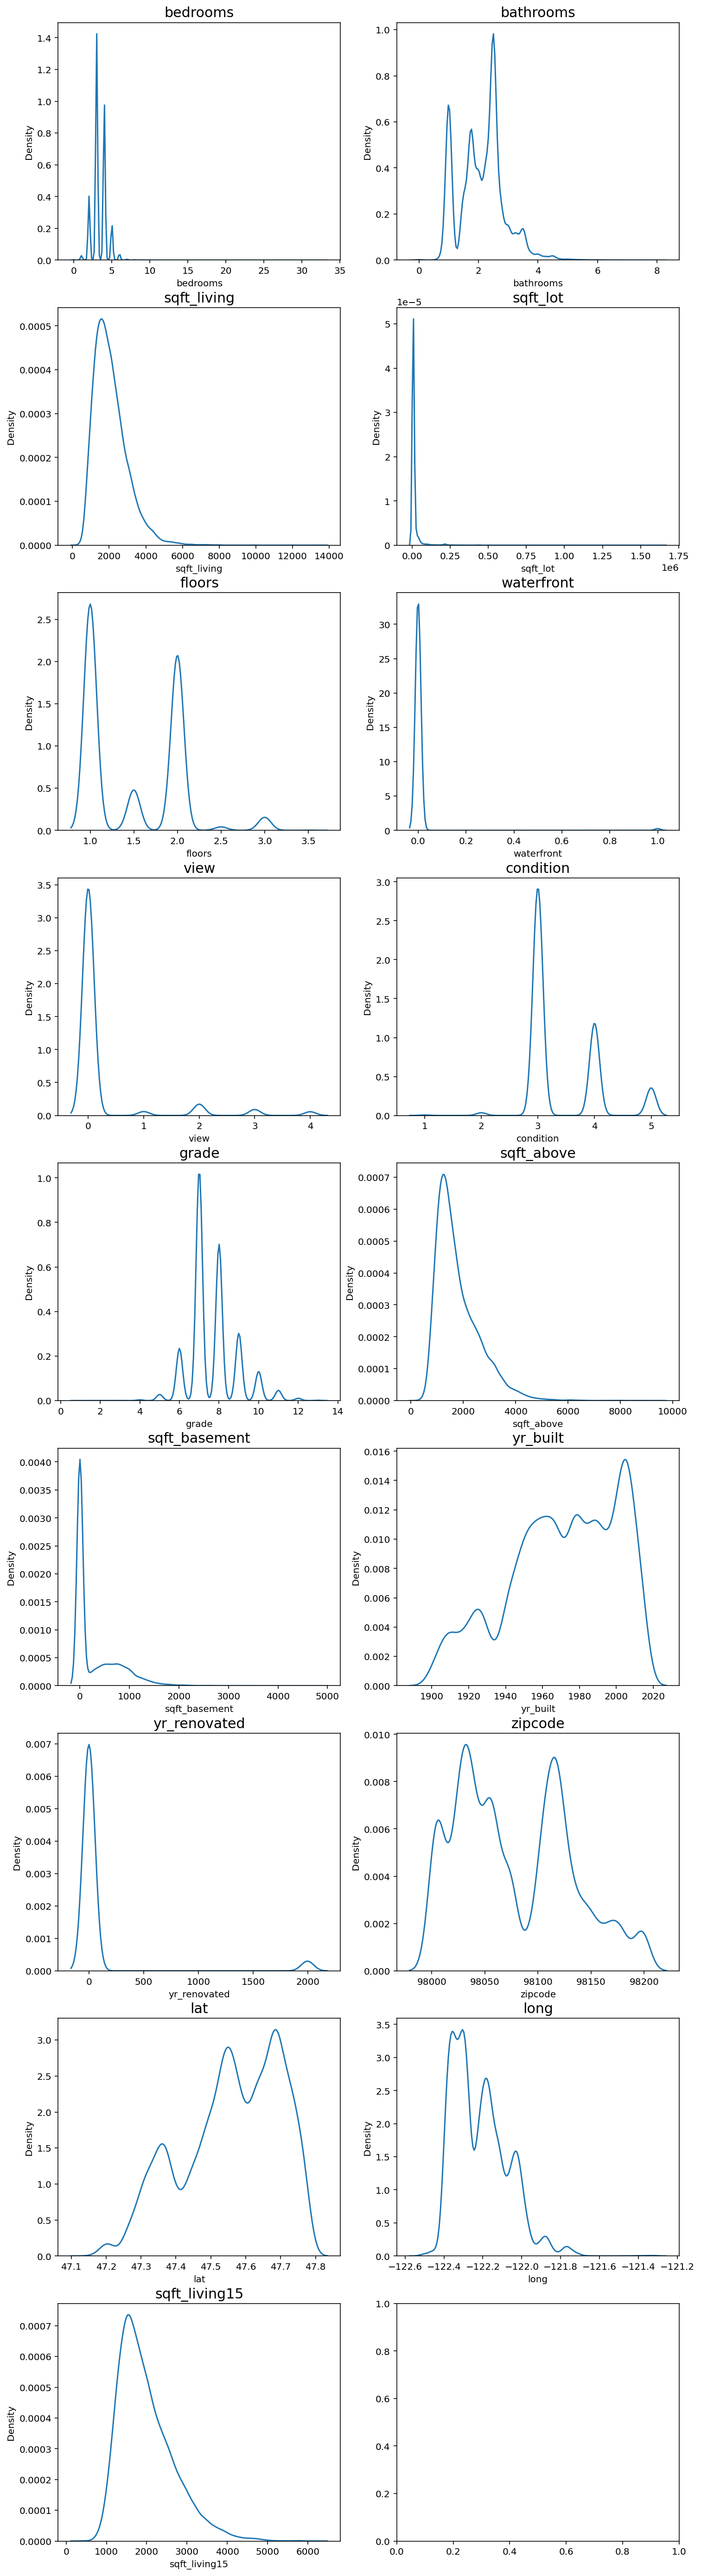

In [19]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = x_train_data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(x_train_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

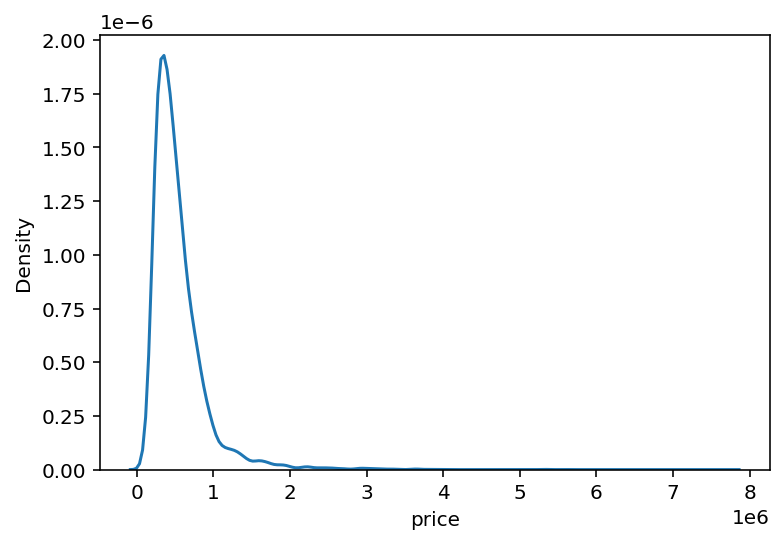

In [20]:
sns.kdeplot(y_train_data)
plt.show()

#### **baseline: 특정 카테고리만 log1p로 로그 변환**

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 등 왜도가 심한 데이터도 있지만 전체적으로 왜도가 다 심한 편입니다. <br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다. 

> log-scaling이 어떻게 치우친 분포를 정규분포로 만들 수 있을까? <br>
로그 함수는 0~1 구간에서는 기울기가 가파릅니다. 즉, x 구간이 0~1로 매우 짧고 그에 비해 y 구간은 -무한대에서 0으로 매우 큽니다. <br>
x값이 0주변에서는 가파른 기울기를 가지고, x값이 점점 커지면 기울기는 급격히 작아집니다.<br> 따라서 x가 큰 값들에서는 차이가 나지 않는 y값들을 가지는 것은 넓은 범위에서는 y값이 모이는 특성을 가지게 할 수 있다는 것입니다. <br>
그럼 치우친 경향을 보이는 그래프에 log를 씌우면? 몰려있는 데이터들이 고르게 펴지게 됩니다.반대로 너무 펴져있는 데이터들은 좀더 작은 범위안으로 모이게 됩니다.

1. 1차 시도 

(시도) 모든 컬럼에 대한 log변환 수행 <br>
(발생이슈) 전체 log를 취해주면, feature importance가 높은 long 컬럼의 내용이 없어집니다. <br>
(해결) long과 lat은 log 변환에서 제외해줘서 에러 해결할 수 있었습니다. <br>

2. 2차 시도 

(시도) long과 lat을 제외한 나머지 컬럼에 대해 모두 log 변환 수행  <br>
(결과) 생각보다 왜도를 전체 처리하고나서 metric 결과가 좋지 않았습니다. <br>

3. 3차 시도 

(시도) 왜도가 심한 특정 컬럼에 대해서만 진행해봤습니다. 전체 컬럼을 했을때 왜도보정을 거치면 정규분포스러워지는 컬럼을 대상으로 진행했습니다. <br>
(결과)


In [21]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15']

for c in skew_columns:
    x_train_data[c] = np.log1p(x_train_data[c].values)
    
# # 2차 시도. 사라졌을 때 문제가 되는 long,lat 다시 업데이트 
# # 추후 이 값으로 다시 engineering 해줄 예정입니다. 
# x_log_transformation['lat'] = x_train_data['lat']
# x_log_transformation['long'] = x_train_data['long']

#### **baseline과 차이점: 앞에서 날짜도 정수형이라 모든 카테고리 log1p로 로그 변환**
np.explm()으로 추후 모델링 값을 예측한 후에 다시 exp(x)-1 값을 반환해줄 예정입니다. 

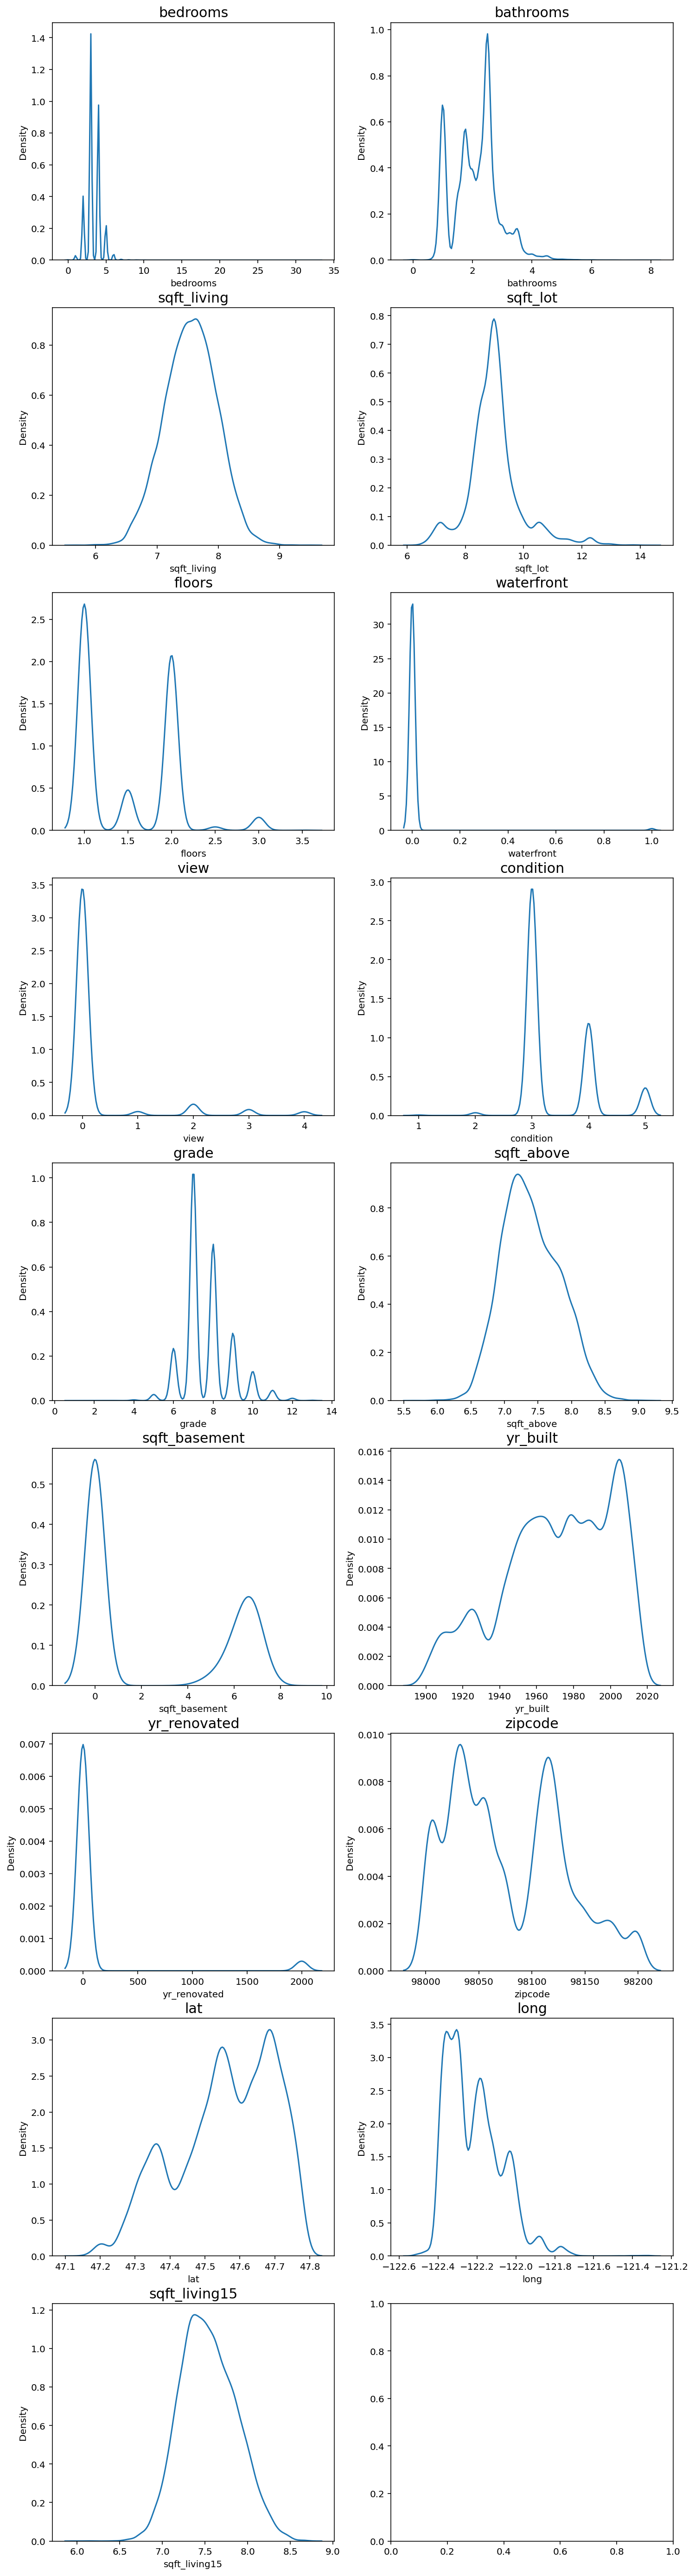

In [22]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = x_train_data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(x_train_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다. 하지만, long과 lat과 같은 값은 주소로 변환해서 사용해줄 수 있으므로 log 변환하지 않겠습니다. <br> 

(시도) y_train에 대한 왜도 보정도 수행합니다. 
(결과) log 변환 결과로 정규분포에 더 가까워짐을 확인할 수 있었습니다.

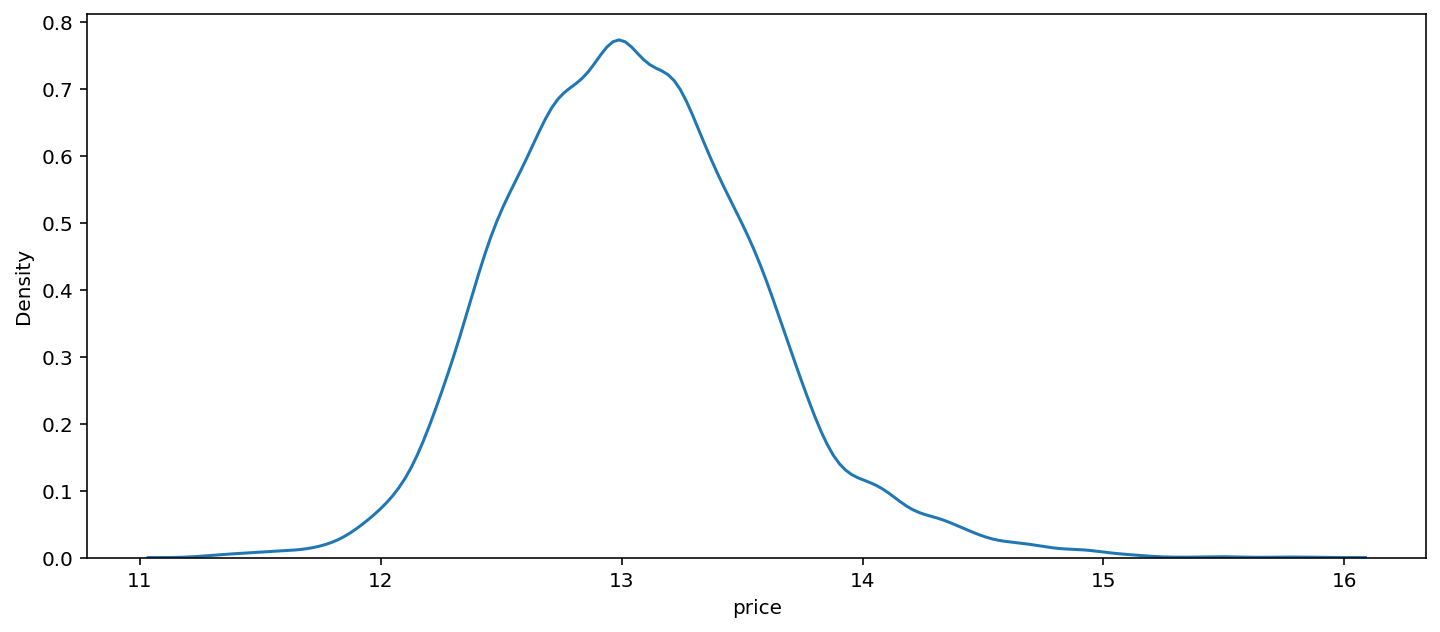

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5)) 
y_train_data = np.log1p(y_train_data)
sns.kdeplot(y_train_data)
plt.show()

1. 1차 시도 

(시도) **왜도가 심하고 baseline을 돌렸을때 feature importance가 낮게 나온, waterfront, yr_renovated, view를 제외해줍니다.** <br>
(결과) 실패, 모델의 성능이 개선되지 않았습니다. 오히려 정답률이 떨어져서 영향이 적은 인자라고 항상 drop해줌으로써 성능을 높일 수 있지 않음을 알 수 있었습니다. 

In [24]:
# pass
# x_log_transformation.drop(['yr_renovated','waterfront'], axis = 1).head()

## 특성 공학 
### total_rooms 추가 
(시도) 영향력이 큰 편에 속하지 않는 bedrooms와 bathrooms를 이용해서 집의 총 방 개수를 구해봤습니다. <br>
(결과)

In [25]:
x_train_data['total_rooms'] = x_train_data['bedrooms'] + x_train_data['bathrooms']
x_train_data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms
0,201410,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,7.201171,5650,4.00
1,201502,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8062,3.00
2,201502,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,7.496097,7503,5.00
3,201406,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,7.713785,6819,5.25
4,201501,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9711,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,7.186144,11303,4.75
6464,201501,3,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,7.244942,1230,5.00
6465,201502,3,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,7.193686,1265,5.50
6466,201406,2,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,6.928538,2007,2.75


### ratio_sqft 추가 

In [26]:
x_train_data['ratio_sqft'] = x_train_data['sqft_living'] / x_train_data['sqft_lot']
x_train_data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,ratio_sqft
0,201410,3,1.00,7.074117,8.639588,1.0,0,0,3,7,...,0.000000,1955,0,98178,47.5112,-122.257,7.201171,5650,4.00,0.818803
1,201502,2,1.00,6.647688,9.210440,1.0,0,0,3,6,...,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8062,3.00,0.721756
2,201502,3,2.00,7.427144,8.997271,1.0,0,0,3,8,...,0.000000,1987,0,98074,47.6168,-122.045,7.496097,7503,5.00,0.825489
3,201406,3,2.25,7.447751,8.827615,2.0,0,0,3,7,...,0.000000,1995,0,98003,47.3097,-122.327,7.713785,6819,5.25,0.843688
4,201501,3,1.50,6.966967,9.181118,1.0,0,0,3,7,...,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9711,4.50,0.758837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,7.313887,9.390075,1.0,0,0,3,6,...,0.000000,2014,0,98010,47.3095,-122.002,7.186144,11303,4.75,0.778895
6464,201501,3,2.00,7.307202,7.027315,3.0,0,0,3,8,...,0.000000,2014,0,98144,47.5699,-122.288,7.244942,1230,5.00,1.039829
6465,201502,3,2.50,7.178545,7.166266,2.0,0,0,3,8,...,4.875197,2008,0,98116,47.5773,-122.409,7.193686,1265,5.50,1.001714
6466,201406,2,0.75,6.928538,7.208600,2.0,0,0,3,7,...,0.000000,2009,0,98144,47.5944,-122.299,6.928538,2007,2.75,0.961149


### total_sqft 추가 
개선되지 않아 삭제했습니다.

In [27]:
x_train_data['total_sqft'] = x_train_data['sqft_living'] + x_train_data['sqft_lot'] + x_train_data['sqft_basement'] + x_train_data['sqft_above']
del x_train_data['total_sqft']

---

## 3. 모델 훈련 

### 3.1. 데이터셋 분리
아까 위에서 Train len으로 저장했던 Index를 활용해서 학습데이터와 테스트 데이터를 분리해줍니다. 

#### **baseline: slicing을 통해 train과 test로 concat split => validaition set X**

In [28]:
X_test = x_train_data.iloc[train_len:, :]
x_train_data = x_train_data.iloc[:train_len, :]

print('x_train_data:', x_train_data.shape)
print('y_train_data: ',y_train_data.shape)
print('X_test: ',X_test.shape)
# y_test는 kaggle이 가지고 있다..!

x_train_data: (15035, 21)
y_train_data:  (15035,)
X_test:  (6468, 21)


In [29]:
# train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
X_train, X_val, y_train, y_val = train_test_split(x_train_data, 
                                                    y_train_data, 
                                                    random_state=random_state, 
                                                    test_size=0.1) # 0.3, 0.2, 0.1

###  3.2. 사용 모델 정의 

In [30]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
#           {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]
models = [gboost, xgboost, lightgbm, rdforest]

In [31]:
gboost.__class__.__name__ # 각 모델 클래스의 내부 속성 확인

'GradientBoostingRegressor'

#### **baseline과 차이점: RMSE값 계산 함수 정의**

In [32]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#### **baseline과 차이점: CV Search로 모델들의 하이퍼 파라미터 추출**
1. 1차 시도 <br>
'n_estimators': [1000, 1200, 1500],
'max_depth': [1, 10],

2. 2차 시도 <br>
'n_estimators': [800, 900, 1000, 1200, 1500],
'max_depth': [-1, 1, 3, 6, 8, 9, 10],
'learning_rate': [0.05, 0.07, 1]

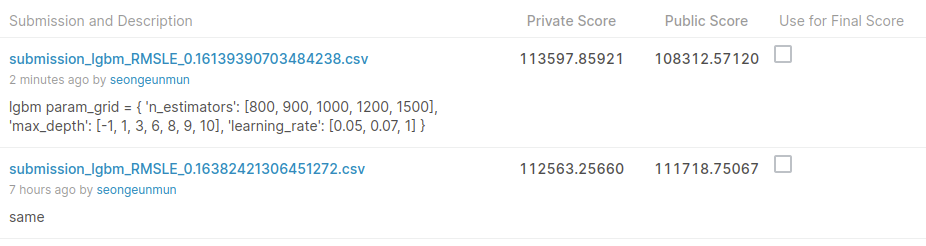
(결과) public은 높아졌지만 private이 더 낮아져버렸습니다. 과적합이 문제일까.. estimators를 줄여준 것이 원인인가 생각되어 다시 수정했습니다.

3. 3차 시도 <br>
'n_estimators': [1000, 1200, 1300, 1500],
'max_depth': [-1, 1, 3, 6, 8, 9, 10],
'learning_rate': [0.05, 0.07, 1] <br>
(결과) private에서 낮아진 현상을 개선할 수 있었습니다. 

4. 4차 시도 <br>
parameter 튜닝으로는 한계가 보여서 특성공학을 시도했습니다. 몇몇 특성들을 추가해줘봤습니다. <br>
total_rooms 추가 <br>
(결과) RMSLE는 낮아지는데 private score는 113662.38928로 더 높아졌습니다... 흑.. <br>
ratio_sqft 추가 <br>
(결과) 112299.52993로 private score가 개선됬습니다!! <br>
total_sqft 추가 <br>
(결과) 113553.69837로 private score가 개선되지않아 해당 특성은 제거했습니다. 

In [33]:
# 탐색할 파라미터의 종류 (딕셔너리로 입력)
param_grid = {
    'n_estimators': [1000, 1200, 1300, 1500],
    'max_depth': [-1, 1, 3, 6, 8, 9, 10],
    'learning_rate': [0.05, 0.07, 1]
}

In [34]:
RandomizedSearchCV.__init__

<function sklearn.model_selection._search.RandomizedSearchCV.__init__(self, estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)>

In [35]:
random_model = RandomizedSearchCV(lightgbm, 
                                  param_distributions=param_grid, \
                                  scoring='neg_mean_squared_error', \
                                  cv=5, 
                                  verbose=2,
                                  n_jobs=5
                                 )

random_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, early_stopping_rounds=50)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    6.2s finished


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=3854), n_jobs=5,
                   param_distributions={'learning_rate': [0.05, 0.07, 1],
                                        'max_depth': [-1, 1, 3, 6, 8, 9, 10],
                                        'n_estimators': [1000, 1200, 1300,
                                                         1500]},
                   scoring='neg_mean_squared_error', verbose=2)

In [36]:
random_model.__class__.__name__

'RandomizedSearchCV'

In [37]:
params = random_model.cv_results_['params']
params

[{'n_estimators': 1200, 'max_depth': -1, 'learning_rate': 0.05},
 {'n_estimators': 1300, 'max_depth': 3, 'learning_rate': 1},
 {'n_estimators': 1200, 'max_depth': 1, 'learning_rate': 0.07},
 {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 1},
 {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1},
 {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.05},
 {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.05},
 {'n_estimators': 1200, 'max_depth': 3, 'learning_rate': 1},
 {'n_estimators': 1500, 'max_depth': 9, 'learning_rate': 0.07},
 {'n_estimators': 1300, 'max_depth': -1, 'learning_rate': 0.05}]

In [38]:
score = random_model.cv_results_['mean_test_score']
score

array([-0.02616546, -0.03667229, -0.03680999, -0.04281226, -0.04259333,
       -0.02633083, -0.02633083, -0.03667229, -0.02621687, -0.02616546])

In [39]:
results = pd.DataFrame(params)
results['score'] = score

results

,n_estimators,max_depth,learning_rate,score
0,1200,-1,0.05,-0.026165
1,1300,3,1.00,-0.036672
2,1200,1,0.07,-0.036810
3,1000,8,1.00,-0.042812
4,1200,6,1.00,-0.042593
5,1000,8,0.05,-0.026331
6,1200,8,0.05,-0.026331
7,1200,3,1.00,-0.036672
8,1500,9,0.07,-0.026217
9,1300,-1,0.05,-0.026165


In [40]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,n_estimators,max_depth,learning_rate,score,RMSE
0,1200,-1,0.05,-0.026165,0.161757
1,1300,3,1.00,-0.036672,0.191500
2,1200,1,0.07,-0.036810,0.191859
3,1000,8,1.00,-0.042812,0.206911
4,1200,6,1.00,-0.042593,0.206382
5,1000,8,0.05,-0.026331,0.162268
6,1200,8,0.05,-0.026331,0.162268
7,1200,3,1.00,-0.036672,0.191500
8,1500,9,0.07,-0.026217,0.161916
9,1300,-1,0.05,-0.026165,0.161757


In [41]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,n_estimators,max_depth,learning_rate,score,RMSLE
0,1200,-1,0.05,-0.026165,0.161757
1,1300,3,1.00,-0.036672,0.191500
2,1200,1,0.07,-0.036810,0.191859
3,1000,8,1.00,-0.042812,0.206911
4,1200,6,1.00,-0.042593,0.206382
5,1000,8,0.05,-0.026331,0.162268
6,1200,8,0.05,-0.026331,0.162268
7,1200,3,1.00,-0.036672,0.191500
8,1500,9,0.07,-0.026217,0.161916
9,1300,-1,0.05,-0.026165,0.161757


In [42]:
results = results.sort_values('RMSLE')
results

,n_estimators,max_depth,learning_rate,score,RMSLE
0,1200,-1,0.05,-0.026165,0.161757
9,1300,-1,0.05,-0.026165,0.161757
8,1500,9,0.07,-0.026217,0.161916
5,1000,8,0.05,-0.026331,0.162268
6,1200,8,0.05,-0.026331,0.162268
1,1300,3,1.00,-0.036672,0.191500
7,1200,3,1.00,-0.036672,0.191500
2,1200,1,0.07,-0.036810,0.191859
4,1200,6,1.00,-0.042593,0.206382
3,1000,8,1.00,-0.042812,0.206911


In [43]:
rmsle_value = results['RMSLE'].min()
rmsle_value

0.16175742159950313

(오류 해결) 아예 값이 같을 때 배열이 2개를 가져오는 경우가 있어서 첫번째 인자로 지정해줬습니다. 

In [44]:
hyper_n = results[results['RMSLE'] == rmsle_value]['n_estimators'].values[0]
hyper_n

1200

In [45]:
hyper_depth = results[results['RMSLE'] == rmsle_value]['max_depth'].values[0]
hyper_lr  = float(results[results['RMSLE'] == rmsle_value]['learning_rate'].values[0])

In [46]:
# def my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5):
#     # GridSearchCV 모델로 초기화
#     grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
#                               cv=5, verbose=verbose, n_jobs=n_jobs)

#     # 모델 fitting
#     grid_model.fit(X_train, y_train)

#     # 결과값 저장
#     params = grid_model.cv_results_['params']
#     score = grid_model.cv_results_['mean_test_score']

#     # 데이터 프레임 생성
#     results = pd.DataFrame(params)
#     results['score'] = score

#     # RMSLE 값 계산 후 정렬
#     results['RMSLE'] = np.sqrt(-1 * results['score'])
#     results = results.sort_values('RMSLE')
    
#     results['name'] = pd.Series([model.__class__.__name__])

#     return results

In [47]:
model = lgb.LGBMRegressor(max_depth=hyper_depth, n_estimators=hyper_n, learning_rate = hyper_lr, random_state=random_state)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
prediction

array([13.13112682, 13.09935376, 14.13201965, ..., 13.05196011,
       12.67220652, 12.97763734])

In [48]:
prediction = np.expm1(prediction)
len(prediction)

6468

In [49]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'submission.csv')
submission = pd.read_csv(submission_path)
# submission.head()
len(submission)

6468

In [50]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.044000e+05
1,15036,4.886255e+05
2,15037,1.372328e+06
3,15038,2.845767e+05
4,15039,3.293401e+05


In [51]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', rmsle_value)
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel-dj19/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.16175742159950313.csv


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

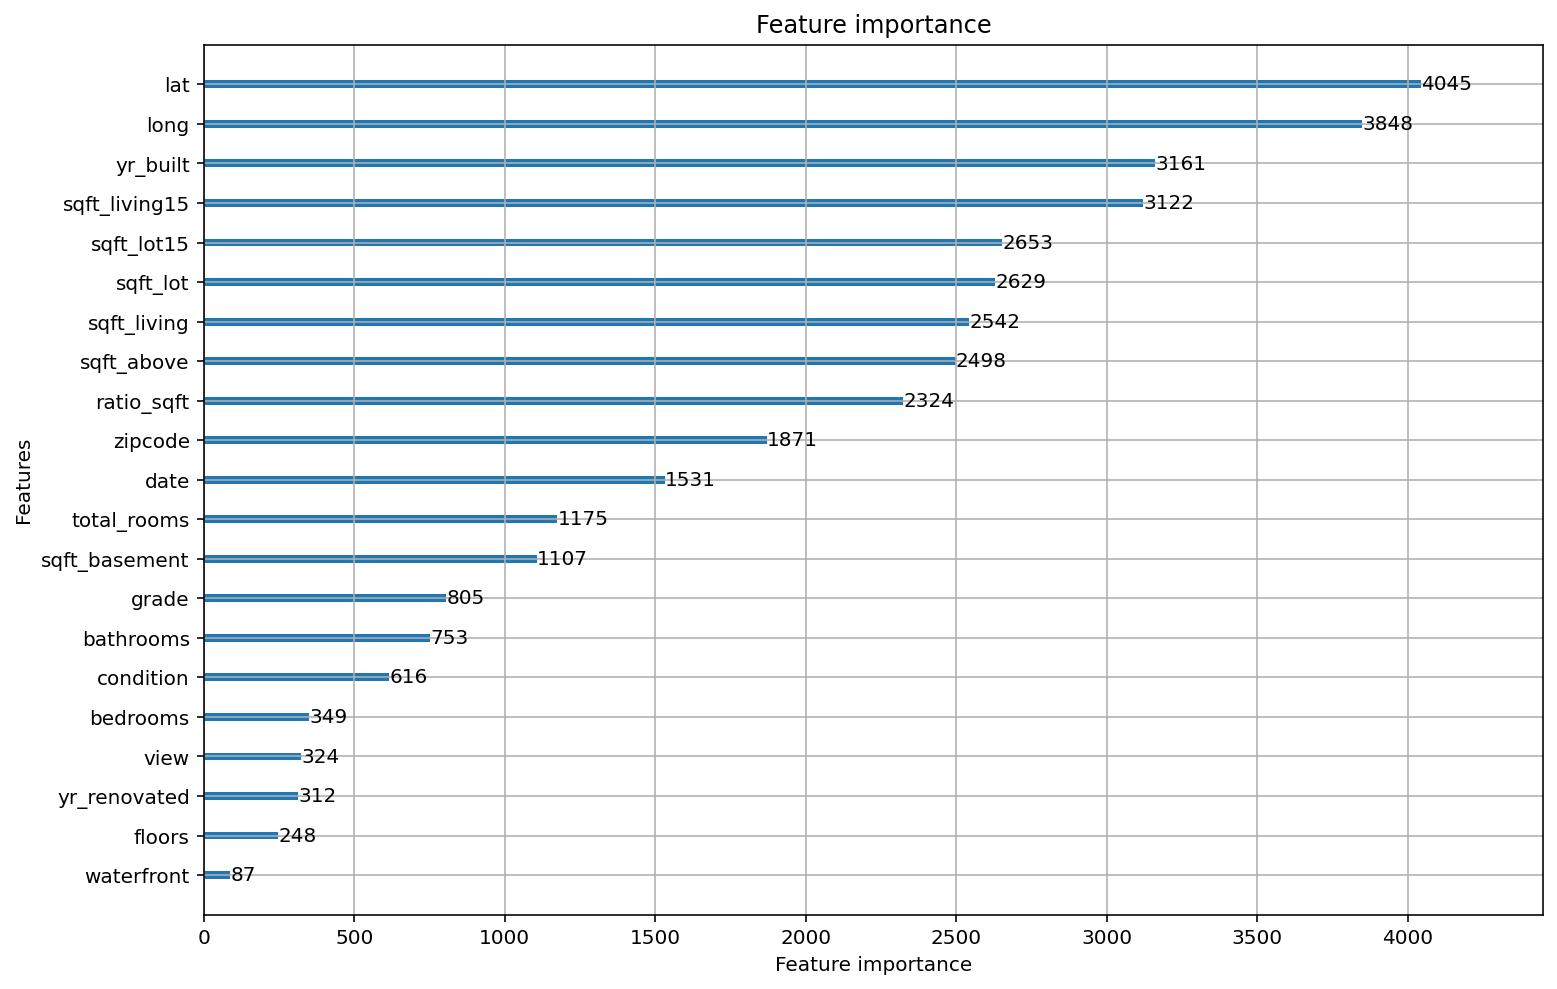

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
lgb.plot_importance(model, ax = ax)

In [53]:
# def save_submission(model, train, y, test, model_name, rmsle=None):
#     model.fit(train, y)
#     prediction = model.predict(test)
#     prediction = np.expm1(prediction)
#     data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
#     submission_path = join(data_dir, 'sample_submission.csv')
#     submission = pd.read_csv(submission_path)
#     submission['price'] = prediction
#     submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
#     submission.to_csv(submission_csv_path, index=False)
#     print('{} saved!'.format(submission_csv_path))

In [54]:
# save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

---

#### **baseline과 차이점: validation set을 활용해서 rmse값을 기준으로 모델의 예측 결과 비교**

In [ ]:
# def get_scores(models, X_train, X_val, y_train, y_val):
#     df = {}

#     for model in models:
#         # 모델 클래스의 내부 속성에서 이름 확보
#         model_name = model.__class__.__name__

#         # 모델 학습
#         model.fit(X_train, y_train)

#         # 예측
#         y_pred = model.predict(X_val)

#         # 예측 결과의 rmse값 저장
#         df[model_name] = rmse(y_val, y_pred)

#         # data frame에 저장
#         score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
#     return score_df

# get_scores(models, X_train, X_val, y_train, y_val)

### 3.2. Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

#### **✓baseline: validation set을 k-fold(k = 5)로 각 모델들의 성능을 확인**
k-fold validation한 결과를 np.mean으로 평균을 내서 각 모델들의 성능을 검증합니다. 

In [ ]:
# def get_cv_score(models):
#     kfold = KFold(n_splits=5, random_state=2020).get_n_splits(x_train.values)
#     for model in models:
#         print("Model {} CV score : {:.4f}".format(model['name'], np.mean(cross_val_score(model['model'], x_train.values, y_train)), 
#                                              kf=kfold))

In [ ]:
# get_cv_score(models)

#### **✓baseline과 차이점: 위에서 Validation을 Train의 20%로 Split 해주는 것으로 대체**
k-fold 방식은 Train set을 다섯등분해서 1/5씩 5회 돌아가면서 Validation set으로 활용하는 방법입니다. 이 방법은 연산량이 매우 많다는 단점이 있습니다. 한 데이터셋의 5배만큼 연산이 이뤄지는 거니까요 

### 3.3. Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.<br>
* [결정계수(R Squared)](https://newsight.tistory.com/259)

#### ✓Average Blending

In [ ]:
# def AveragingBlending(models, x_train, y_train, x_test):
#     for model in models : 
#         model['model'].fit(x_train.values, y_train)
    
#     predictions = np.column_stack([
#         model['model'].predict(x_test.values) for model in models
#     ])
#     return np.mean(predictions, axis=1)

# print('💢')

## 모델 예측 및  평가

In [ ]:
# y_pred = AveragingBlending(models, x_train, y_train, x_test)
# print(len(y_pred))
# y_pred

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# def rmse(y_test, y_pred):
#     return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

## 제출

In [ ]:
# ## 위에 코드와 동일한 역할 수행함 
# sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
# sub.to_csv('submission.csv', index=False)

In [ ]:
# submission_path = join(data_path, 'blending_submission.csv') # first baseline
# submission = pd.read_csv(submission_path)
# submission.head()

In [ ]:
# result = pd.DataFrame({
#     'id' : test_id, 
#     'price' : y_pred
# })

# result.head()

In [ ]:
# my_submission_path = join(data_path, 'base_tuning_submission.csv')
# result.to_csv(my_submission_path, index=False)

# print(my_submission_path)

## 루브릭 
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가? 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다. <br>
* 데이터 전처리 
* 특성 공학 
* 교차 검증 - Random Search 
* 모델 학습 - XGBoost, LGBM Regressor 
* 예측 

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가? 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.  <br>
* 이해를 돕도록 추가 코드와 baseline과의 차이점에 대해 각 시도, 결과와 매칭하여 서술했습니다. 

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가? 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.  <br>
* LGBM Regressor - 111000점 정도의 점수를 얻었습니다. 

## 회고

### Hyper-parameter  - lightGBM/ XGBoost 
ensemble과 같은 경우 구조자체가 파라미터에 맞게 맞춰져 그다지 정확도면에서 차이가 없을 수 있다고 합니다. 따라서 각 모델들의 파라미터를 블로그에 나온 우선순위를 위주로 파라미터를 정리해봤습니다. <br>
* 참고 링크: http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/ <br>

1. 예측력에 큰 영향을 주는 파라미터(먼저, 최적 파라미터 찾기) 
* learning rate/ eta
    * 주로 0.05~0.1 정도로 맞추고 그 이상이면 다른 파라미터를 튜닝할때 미세하게 조정하고 싶으면 더 작게 두기도하나, 한번 다른 파라미터를 고정하면 바꿀 필요는 없습니다. 
    * 굳이 긴 소수점으로 튜닝할 필요없습니다. 
* num_iterations/ nrounds
    * 너무 크게하면 오버피팅 되나, early_stoping을 설정해주면 크게 줘도 오버피팅을 방지할 수 있다. 
    * lightgbm default = 100이나 너무 적으므로 일반적으로 1000이상의 값을 줍니다. 
* early_stopping_round/ early_stopping_rounds
    * valid set이 있을 때 사용하며, valid set이 정해진 수만큼 발전 없으면 그만두게 설정합니다. 
* max_depth 
    * feature 개수가 많을수록 높게 설정합니다. 
    * 파라미터 설정시 제일 먼저 설정합니다. 
    * default max_depth = -1이고 무제한 분기를 의미합니다. 

2. 일반적인 값을 사용하는 파라미터(일반적인 파라미터값을 사용 or 이후 세부적인 튜닝)
* feature_fraction/ colsample_bytree
    * default feature_fraction = 1입니다. 
    * 0.7~0.9로 주로 세팅하는 편이다. 
* scale_pos_weight
    * 데이터셋의 불균형이 심할 때 1.1~1.5로 조정합니다. 
    * 이외의 상황에선 주로 default scale_pos_weight = 1입니다. 
    
3. 주의가 필요한 파라미터(default로 사용) 
* bagging_fraction/ subsample
* lambda_l1/ alpha
* lambda_l2/ lambda
* max_bin